# rsHRF explore

A.L. 2022-03-02

See the README.md file

```
conda deactivate                                             # no conda environments (even not "base")
sage --pip install rsHRF                                     # install the rsHRF toolbox in sage
sage --pip install nilearn                                   # install the Nilearn package in sage
sage --pip install mat4py                                    # load & save data in Matlab format in sage
sage --pip install git+https://github.com/ANTsX/ANTsPy.git   # install ANTsPy package in sage (long time)

sage -n                                          # start a Jupyter Notebook (with the SageMath 9.5 kernel)
```


For some nice **visualization tools**, check:

- https://nanslice.readthedocs.io/en/latest (`pip install nanslice`)  and https://hub.gke2.mybinder.org/user/spinicist-nanslice-rnukq9z8/notebooks/doc/example.ipynb 
- https://github.com/rordenlab/MRIcroGL from Chris Rorden lab: v1.2 GLSL volume rendering. Able to view NIfTI, DICOM, MGH, MHD, NRRD, AFNI format imag

In [1]:
!rsHRF --help

usage: rsHRF [-h]
             (--ts TS | --input_file INPUT_FILE | --bids_dir [BIDS_DIR] | --GUI)
             [--output_dir OUTPUT_DIR] [--n_jobs N_JOBS] [-V]
             [--analysis_level [{participant}]]
             [--participant_label PARTICIPANT_LABEL [PARTICIPANT_LABEL ...]]
             [--bids_filter_file BIDS_FILTER_FILE]
             [--atlas ATLAS | --brainmask]
             [--estimation {canon2dd,sFIR,FIR,fourier,hanning,gamma}]
             [--passband LOW_FREQ HIGH_FREQ]
             [--passband_deconvolve LOW_FREQ HIGH_FREQ] [-TR TR] [-T T]
             [-T0 T0] [-TD_DD TD_DD] [-AR_lag AR_LAG] [--thr THR]
             [--temporal_mask TEMPORAL_MASK] [--order ORDER] [--len LEN]
             [--min_onset_search MIN_ONSET_SEARCH]
             [--max_onset_search MAX_ONSET_SEARCH] [--localK LOCALK]
             [--wiener]

retrieves the onsets of pseudo-events triggering a haemodynamic response from
resting state fMRI BOLD voxel-wise signal

optional arguments:
  -h, --

## BIDS 

Go to http://bids-standard.github.io/bids-validator/ and select a folder with your BIDS dataset (e.g. ./data/mybids)

### Extract a single voxel timecourse from the rs-fMRI recording in sub-01

`rsHRF --ts input_file.txt --estimation hanning --output_dir results -TR 2.0`

In [85]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nibabel as nib
import nilearn
import ants
import matplotlib.pyplot as plt


mydir= './data/mybids'
mysubj = '01'

rest_name = f'{mydir}/sub-{mysubj}/func/sub-{mysubj}_task-rest_bold'
anat_name = f'{mydir}/sub-{mysubj}/anat/sub-{mysubj}_T1w'

rest_img_fn = f'{rest_name}.nii.gz'
rest_json_fn = f'{rest_name}.json'

anat_img_fn = f'{anat_name}.nii.gz'
anat_json_fn = f'{anat_name}.json'

rest_img = nib.load(rest_img_fn)
anat_img = nib.load(anat_img_fn)
 

with open(rest_json_fn) as json_data:
    jdata = json.load(json_data)

In [46]:
jdata.items()

dict_items([('AcquisitionMatrixPE', 64), ('AcquisitionNumber', 1), ('AcquisitionTime', '14:37:26.780000'), ('BandwidthPerPixelPhaseEncode', 48.077), ('BaseResolution', 64), ('BodyPartExamined', 'BRAIN'), ('ConsistencyInfo', 'N4_VD13D_LATEST_20130810'), ('ConversionSoftware', 'dcm2niix'), ('ConversionSoftwareVersion', 'v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1900'), ('DerivedVendorReportedEchoSpacing', 0.000649999), ('DeviceSerialNumber', '66035'), ('DwellTime', 4.4e-06), ('EchoTime', 0.03), ('EchoTrainLength', 31), ('EffectiveEchoSpacing', 0.000324999), ('FlipAngle', 90), ('ImageComments', 'Reference_volume_for_motion_correction.'), ('ImageOrientationPatientDICOM', [0.996788, 0.00126201, 0.0800744, 3.94129e-09, 0.999876, -0.0157585]), ('ImageType', ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'MOCO', 'MOSAIC']), ('ImagingFrequency', 123.256), ('InPlanePhaseEncodingDirectionDICOM', 'COL'), ('InstitutionAddress', 'NA'), ('InstitutionName', 'NA'), ('InstitutionalDepartmentName', 'NA'), ('MR

**Find TR time**

In [47]:
for key, value in jdata.items(): 
    if key == 'RepetitionTime':
        TR = value
        print(f"TR in  subj-{mysubj}'s rs-fMRI recording is {value} sec")

TR in  subj-01's rs-fMRI recording is 2.24 sec


**Find other information about the rs-fMRI recording**

In [48]:
print('functional file name', rest_img.get_filename())
print('shape of image = ', rest_img.header.get_data_shape())
print('units = ', rest_img.header.get_xyzt_units())
print('voxel size = ', rest_img.header.get_zooms())
print('dtype = %s' % rest_img.header.get_data_dtype())
data = rest_img.get_fdata()
print('data shape', data.shape)
print('min = %d' % data.min())
print('max = %d' % data.max())
print('number of timepoints =', rest_img.shape[-1])

functional file name ./data/mybids/sub-01/func/sub-01_task-rest_bold.nii.gz
shape of image =  (64, 64, 40, 200)
units =  ('mm', 'sec')
voxel size =  (3.0, 3.0, 3.3, 2.24)
dtype = int16
data shape (64, 64, 40, 200)
min = 0
max = 1882
number of timepoints = 200


**Find information about the 3D T1w MRI recording**

In [49]:
print('structural file name', anat_img.get_filename())
print('shape of image = ', anat_img.header.get_data_shape())
print('units = ', anat_img.header.get_xyzt_units())
print('voxel size = ', anat_img.header.get_zooms())
print('dtype = %s' % anat_img.header.get_data_dtype())
sdata = anat_img.get_fdata()
print('data shape', sdata.shape)
print('min = %d' % sdata.min())
print('max = %d' % sdata.max())

structural file name ./data/mybids/sub-01/anat/sub-01_T1w.nii.gz
shape of image =  (192, 256, 256)
units =  ('mm', 'sec')
voxel size =  (1.0, 1.0, 1.0)
dtype = int16
data shape (192, 256, 256)
min = 0
max = 2718


## Using ANTsPy functions

See: https://antspy.readthedocs.io/en/latest

In [60]:
aimg = ants.image_read(anat_img_fn)   # 3D T1w MRI
fimg = ants.image_read(rest_img_fn)   # 4D rs-fMRI BOLD

In [61]:
aimg

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (192, 256, 256)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (105.4421, 86.7565, -120.4132)
	 Direction  : [-9.963e-01  3.900e-03 -8.530e-02 -3.900e-03 -1.000e+00 -3.000e-04
 -8.530e-02 -0.000e+00  9.964e-01]


In [62]:
fimg

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64, 40, 200)
	 Spacing    : (3.0, 3.0, 3.3, 2.24)
	 Origin     : (-92.1086, 55.6764, -45.2941, 0.0)
	 Direction  : [ 0.9968 -0.     -0.0801  0.      0.0013 -0.9999  0.0157  0.      0.0801
  0.0158  0.9967  0.      0.      0.      0.      1.    ]


### Masking the data: from 4D image to 2D array

While functional neuroimaging data consist in 4D images, positioned in a coordinate space (which we will call Niimgs). For use with the scikit-learn, they need to be converted into 2D arrays of samples and features.

![img](https://nilearn.github.io/_images/niimgs.jpg)

$$
\Bigg\downarrow
$$


![img](https://nilearn.github.io/_images/feature_array.jpg)

We use masking to convert 4D data (i.e. 3D volume over time) into 2D data (i.e. voxels over time). For this purpose, we use the NiftiMasker object, a very powerful data loading tool.

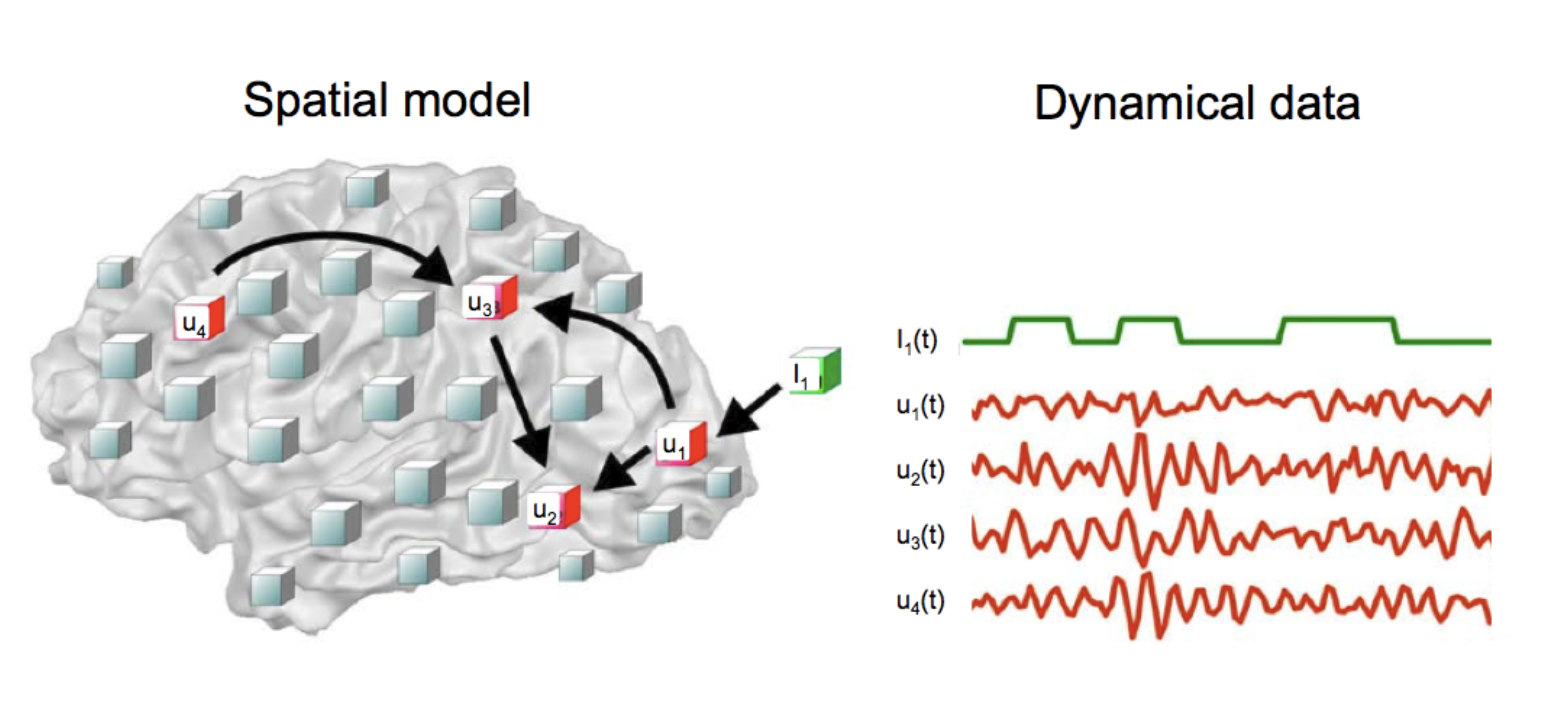

In [225]:
from IPython.display import Image
Image(filename='./assets/network_brain_spatial_dynamic.png', width=800)

#### Extracting brain mask from 4D rs-fMRI

In [64]:
from nilearn.masking import compute_epi_mask


rest_img = nib.load(rest_img_fn)
mask_img = compute_epi_mask(rest_img_fn)

In [130]:
# Get voxel dimensions
voxel_dims = (rest_img.header["pixdim"])[1:4]
print("Voxel dimensions:")
print("  x = {} mm".format(voxel_dims[0]))
print("  y = {} mm".format(voxel_dims[1]))
print("  z = {} mm".format(voxel_dims[2]))

# Compute volume
nonzero_voxel_count = np.count_nonzero(mask_img.get_fdata())
nonzero_voxel_count2 = np.sum(mask_img.get_fdata() != 0)

voxel_volume = np.prod(voxel_dims)
nonzero_voxel_volume = nonzero_voxel_count * voxel_volume

print("Number of non-zero voxels = {}".format(nonzero_voxel_count))
print("Volume of non-zero voxels = {} mm^3".format(nonzero_voxel_volume))
nonzero_voxel_count2

Voxel dimensions:
  x = 3.0 mm
  y = 3.0 mm
  z = 3.299999952316284 mm
Number of non-zero voxels = 46798
Volume of non-zero voxels = 1389900.5464439392 mm^3


46798

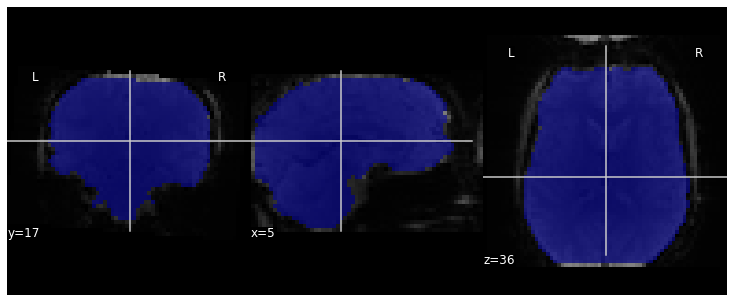

In [122]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img


mean_rest = mean_img(rest_img)

fig = plt.figure(figsize=(10, 4))

plot_roi(mask_img, mean_rest, figure=fig)
plt.show()

#### Applying the mask to extract the corresponding time series

In [73]:
from nilearn.masking import apply_mask

masked_data = apply_mask(rest_img_fn, mask_img)


# masked_data shape is (timepoints, voxels)
masked_data.shape

(200, 46798)

#### Plotting a couple of voxel time courses withinin the brain mask

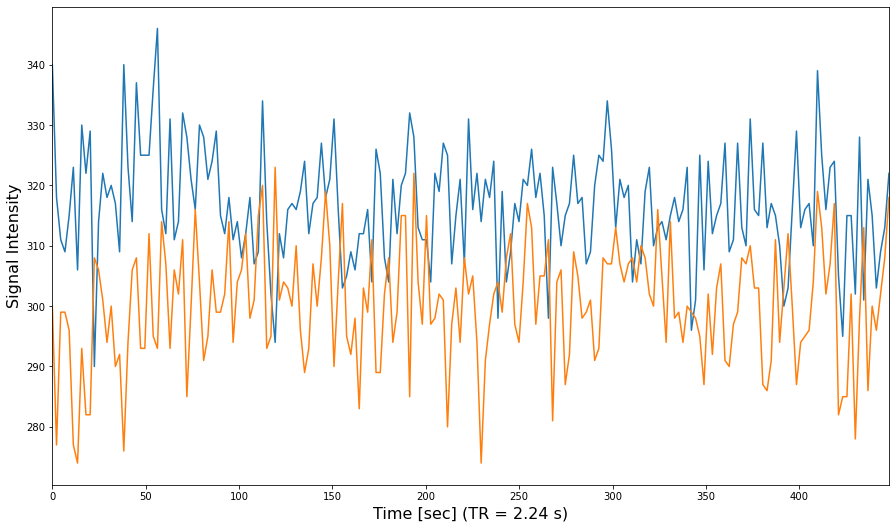

In [90]:
plt.figure(figsize=(14, 8))

ns = rest_img.shape[-1]
x = np.linspace(0.0, ns*TR, ns)

plt.plot(x, masked_data[:, :2])
plt.xlabel(f'Time [sec] (TR = {TR} s)', fontsize=16)
plt.ylabel('Signal Intensity', fontsize=16)
plt.xlim(0, ns*TR)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

### Visualizing global patterns over time

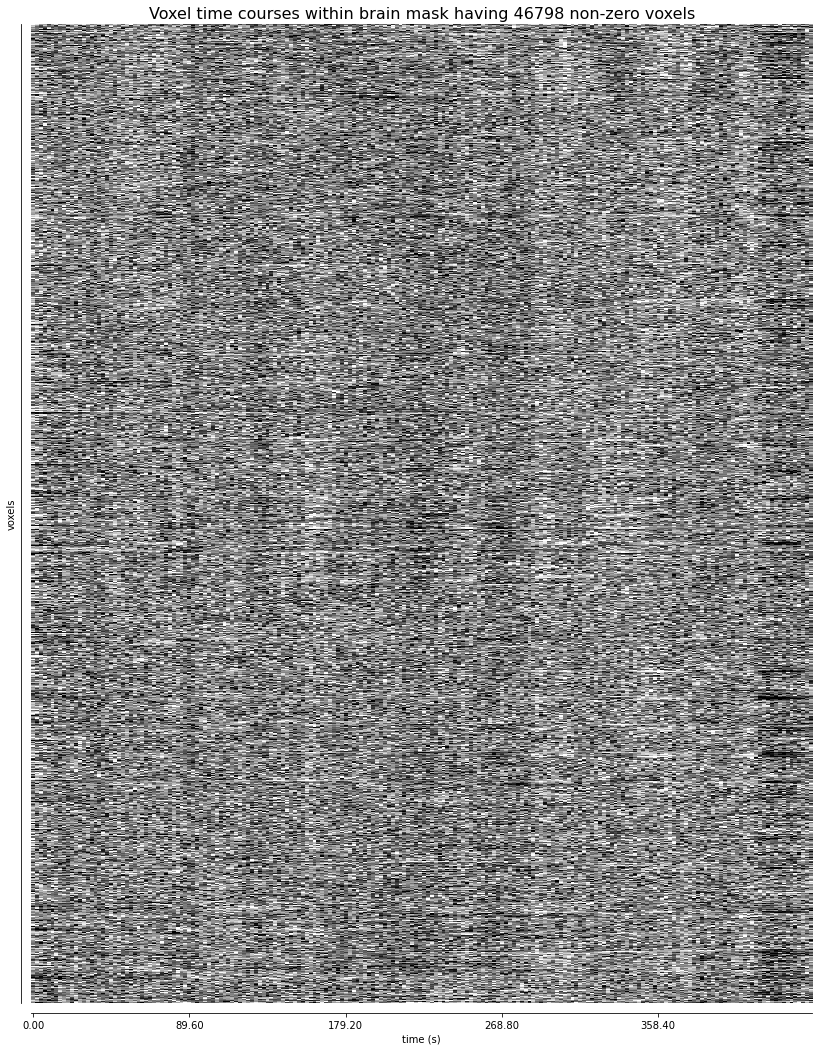

In [128]:
#import matplotlib
#matplotlib.use('TkAgg')

from nilearn.plotting import plot_carpet

fig = plt.figure(figsize=(14, 18))               
display = plot_carpet(rest_img, mask_img, figure=fig)
plt.title(f'Voxel time courses within brain mask having {nonzero_voxel_count} non-zero voxels', size=16)
plt.show()

#### Find (i,j,k) coordinates of brain mask using `np.where()`

In [188]:
rest_data = rest_img.get_fdata()
mask_data = mask_img.get_fdata()

ii, jj, kk = np.where(mask_data == 1)
print(len(ii), len(jj), len(kk))
print(ii[0], jj[0], kk[0])

46798 46798 46798
9 16 21


In [189]:
rest_data.shape

(64, 64, 40, 200)

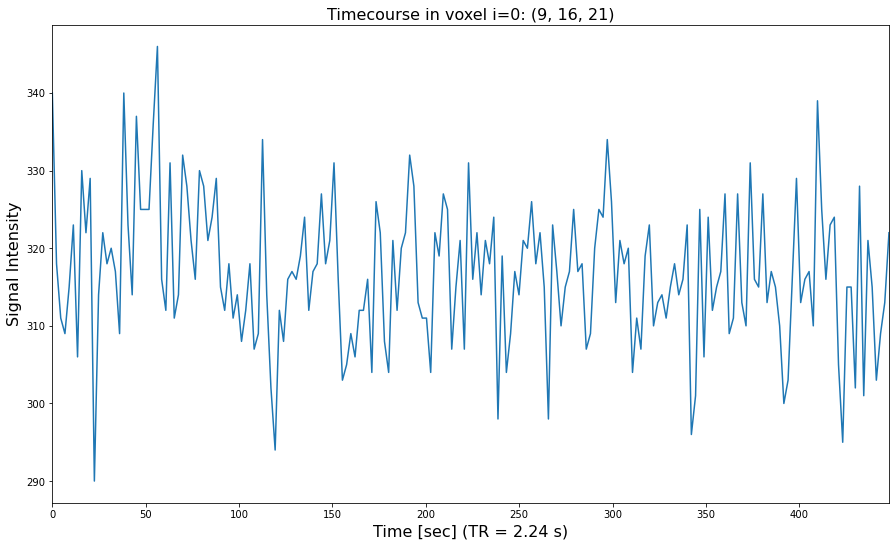

In [212]:
plt.figure(figsize=(14, 8))

ns = rest_img.shape[-1]
x = np.linspace(0.0, ns*TR, ns)

for i in [0]: # [0, 1, 2]:
    plt.plot(x, rest_data[ii[i], jj[i], kk[i], :])
plt.xlabel(f'Time [sec] (TR = {TR} s)', fontsize=16)
plt.ylabel('Signal Intensity', fontsize=16)
plt.xlim(0, ns*TR)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
plt.title(f'Timecourse in voxel i={i}: ({ii[i]}, {jj[i]}, {kk[i]})', size=16)
plt.show()

**Select the i-th voxel timecourse in the brain mask and save its SI-values to text file**

In [206]:
i=0
time_course = rest_data[ii[i], jj[i], kk[i], :]

with open("./data/input_file.txt", "a") as f:
    for item in list(time_course):
        f.write(str(item) + "\n")

**Displaying the contents of the text file**

In [218]:
file = open("./data/input_file.txt", "r")
content = file.read()

print("Array contents of 50 first characters in input_file.txt:\n ", content[0:50])
file.close()

Array contents of 50 first characters in input_file.txt:
  340.0
318.0
311.0
309.0
315.0
323.0
306.0
330.0
32


## The rsHRF analysis of a single voxel timecourse

In [203]:
!rsHRF --ts ./data/input_file.txt --estimation hanning --output_dir ./data/results -TR 2.24

Retrieving HRF ...
Assuming non interactive session since isatty found missing
Done
Deconvolving HRF ...
Done
Saving Output ...
Done


**Check results**

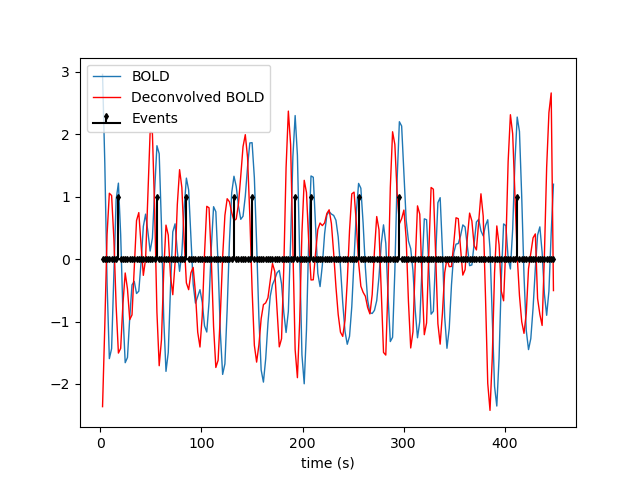

In [229]:
from IPython.display import Image
Image(filename='./data/results/input_file_deconvolution_plot.png', width=900)

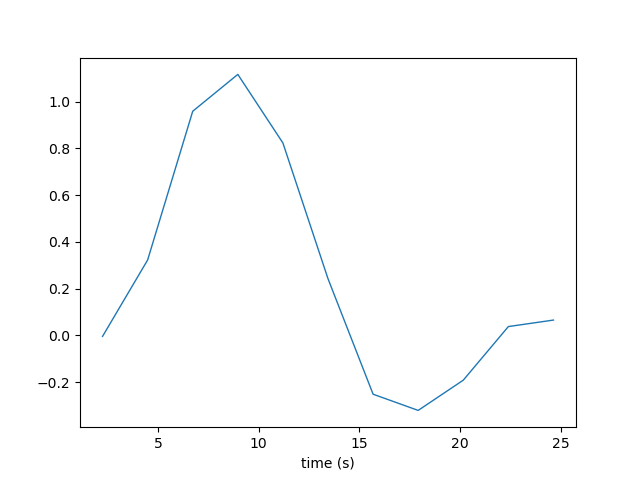

In [228]:
from IPython.display import Image
Image(filename='./data/results/input_file_hrf_plot.png', width=900)

In [231]:
import scipy.io

mat = scipy.io.loadmat('./data/results/input_file_hrf_deconv.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Mar  2 21:13:29 2022',
 '__version__': '1.0',
 '__globals__': [],
 'para': array([[(array(['hanning'], dtype='<U7'), array([[0.01, 0.08]]), array([[0.00000000e+000, 1.79769313e+308]]), array([[2.24]]), array([[3]]), array([[1]]), array([[2]]), array([[1]]), array([[1]]), array([], shape=(0, 0), dtype=float64), array([[3]]), array([[24]]), array([[4]]), array([[8]]), array([[2]]), array([[0]], dtype=uint8), array([[0.74666667]]), array([[ 5,  6,  7,  8,  9, 10]]))]],
       dtype=[('estimation', 'O'), ('passband', 'O'), ('passband_deconvolve', 'O'), ('TR', 'O'), ('T', 'O'), ('T0', 'O'), ('TD_DD', 'O'), ('AR_lag', 'O'), ('thr', 'O'), ('temporal_mask', 'O'), ('order', 'O'), ('len', 'O'), ('min_onset_search', 'O'), ('max_onset_search', 'O'), ('localK', 'O'), ('wiener', 'O'), ('dt', 'O'), ('lag', 'O')]),
 'hrfa': array([[ 0.        ],
        [ 0.03309681],
        [ 0.14245139],
        [ 0.32341769],
        [ 0.5472048

### Load data from a MAT-file using `mat4py`

https://pypi.org/project/mat4py

`pip install mat4py`

The function loadmat loads all variables stored in the MAT-file into a simple Python data structure, using only Python’s dict and list objects. Numeric and cell arrays are converted to row-ordered nested lists. Arrays are squeezed to eliminate arrays with only one element. The resulting data structure is composed of simple types that are compatible with the JSON format.

In [234]:
from mat4py import loadmat

mat = loadmat('./data/results/input_file_hrf_deconv.mat')
mat

{'para': {'estimation': 'hanning',
  'passband': [0.01, 0.08],
  'passband_deconvolve': [0.0, 1.7976931348623157e+308],
  'TR': 2.24,
  'T': 3,
  'T0': 1,
  'TD_DD': 2,
  'AR_lag': 1,
  'thr': 1,
  'temporal_mask': [],
  'order': 3,
  'len': 24,
  'min_onset_search': 4,
  'max_onset_search': 8,
  'localK': 2,
  'wiener': 0,
  'dt': 0.7466666666666667,
  'lag': [5, 6, 7, 8, 9, 10]},
 'hrfa': [[0.0],
  [0.033096814869391374],
  [0.1424513927598755],
  [0.32341768867404724],
  [0.5472048241194946],
  [0.7717100545572266],
  [0.9569537777758307],
  [1.077723099782577],
  [1.1279731755522693],
  [1.1162142687454384],
  [1.0558529973641693],
  [0.956647981031384],
  [0.822011102935054],
  [0.6528652828683565],
  [0.45463091329507566],
  [0.2420959815824206],
  [0.038414299693277545],
  [-0.1317373946404125],
  [-0.2510882611097426],
  [-0.31564590781876134],
  [-0.33415005344443416],
  [-0.3215882885713434],
  [-0.29080412962372104],
  [-0.24729747195001445],
  [-0.19022456369098834],
  [-0.

In [236]:
mat.keys()

dict_keys(['para', 'hrfa', 'event_bold', 'PARA', 'event_number', 'data_deconv'])

# NEXT steps:

- Region-wisw analysis (e.g. insula, basal ganglia)
- Group-wise analysis (e.g. IBS, PD, ...)

## Resample to MNI152 space obtaining `rimg` and `simg` using Nilearn

#### Registration (aka spatial normalization)

(From: http://jpeelle.net/mri/image_processing/registration.html)

A goal common to many neuroimaging studies is to learn something about how patterns of brain activity generalize from the volunteers tested to a broader population. In the case of MRI, this generally involves registering a group of participants’ brains into a common space. If the patterns of neural activation have a systematic relationship to macroanatomical structure (see below), then lining up these structures across volunteers allows us to make inferences about the level of group activity.


![img](http://jpeelle.net/mri/_images/registration.png)

In [63]:
from nilearn.image import resample_to_img
from nilearn.image.image import mean_img

rimg = rest_img
simg = anat_img

mean_rimg = mean_img(rimg)

resampled_simg = resample_to_img(simg, mean_rimg)

print('resampled_simg.shape\n', resampled_simg.shape)
print('rimg.shape\n', rimg.shape)
print('resampled_simg.affine\n', resampled_simg.affine)
print('rimg.affine\n', rimg.affine)

/home/arvid/SW/sage-9.5/local/var/lib/sage/venv-python3.8/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning:

Casting data from int16 to float32



resampled_simg.shape
 (64, 64, 40)
rimg.shape
 (64, 64, 40, 200)
resampled_simg.affine
 [[-2.99036431e+00  1.18238823e-08  2.64278293e-01  9.21085968e+01]
 [-3.78602091e-03  2.99962759e+00 -5.18361032e-02 -5.56763763e+01]
 [ 2.40223154e-01  4.72755767e-02  3.28899240e+00 -4.52940598e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
rimg.affine
 [[-2.99036431e+00  1.18238823e-08  2.64278293e-01  9.21085968e+01]
 [-3.78602091e-03  2.99962759e+00 -5.18361032e-02 -5.56763763e+01]
 [ 2.40223154e-01  4.72755767e-02  3.28899240e+00 -4.52940598e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Coordinates of Default Mode (MNI152 space)**

In [52]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
          'Posterior Cingulate Cortex',
          'Left Temporoparietal junction',
          'Right Temporoparietal junction',
          'Medial prefrontal cortex',
         ]
dmn_node_cols = ['r', 'g', 'b', 'k']

mean_rimg:


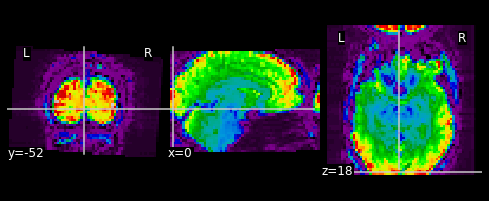

In [53]:
from nilearn import plotting
from nilearn.plotting import plot_epi, plot_anat, show

print('mean_rimg:')
plot_epi(mean_rimg, cut_coords=dmn_coords[0])
plotting.show()

resampled_simg:


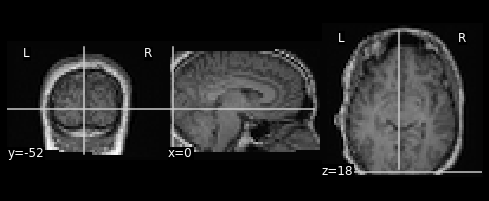

In [54]:
print('resampled_simg:')
plot_epi(resampled_simg, cmap = 'gray', cut_coords=dmn_coords[0])
plotting.show()